In [1]:
from sklearn.neighbors import NearestNeighbors
import glob
import random
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt
import math

In [2]:
data_path = ['/Users/soroush/Desktop/1/*.txt', '/Users/soroush/Desktop/2/*.txt', '/Users/soroush/Desktop/3/*.txt',
             '/Users/soroush/Desktop/4/*.txt', '/Users/soroush/Desktop/5/*.txt']

In [3]:
training_set = []
test_set = []
training_labels = []
test_labels = []
# feature vector size
feature_size = 0
minority_class = []
majority_class = []
k_kkn = 5

In [4]:
def prepare_data(path, return_feature_size=True):
    del training_set[:]
    del test_set[:]
    del training_labels[:]
    del test_labels[:]
    del minority_class[:]
    del majority_class[:]

    files = glob.glob(path)
    for fle in files:
        with open(fle) as f:
            if "tra" in fle:
                lines = f.readlines()
                for line in lines:
                    temp = line.split(",")
                    label = temp[-1]
                    del temp[-1]
                    temp = [float(i) for i in temp]

                    if label == ' negative\n':
                        training_labels.append(-1)
                        majority_class.append(temp)
                    else:
                        training_labels.append(1)
                        minority_class.append(temp)

                    training_set.append(temp)
            elif "tst" in fle:
                lines = f.readlines()
                for line in lines:
                    temp = line.split(",")
                    label = temp[-1]
                    del temp[-1]
                    temp = [float(i) for i in temp]

                    if label == ' negative\n':
                        test_labels.append(-1)
                    else:
                        test_labels.append(1)

                    test_set.append(temp)

    if return_feature_size:
        return len(training_set[0])
    else:
        return


In [5]:
def smote(n, k, sample_class):
    """ smote method main function
    :param n: number of new sample
    :param k: k of knn
    :param sample_class : all minority sample
    :return:
    """

    # for tracking number of generated synthetic samples
    newindex = 0
    synthetic = []

    while n != 0:
        i = random.randint(1, len(sample_class)) - 1
        populate(i, get_nearest_neighbor(sample_class[i], k), k, synthetic, newindex, sample_class)
        n = n - 1

    return synthetic


In [6]:
def get_nearest_neighbor(x_test, k):
    """ calculate k nearest neighbor and return their indices
    :param x_test: the current data we want to find his neighbor
    :param k: k of knn
    :return: k nearest neighbor indices
    """
    # create list for distances and targets
    distances = []
    targets_index = []

    for i in range(len(minority_class)):
        if minority_class[i][:] != x_test:
            # first we compute the euclidean distance
            distance = np.sqrt(np.sum(np.square(np.array(x_test) - np.array(minority_class[i][:]))))
            # add it to list of distances
            distances.append([distance, i])

    # sort the list
    distances = sorted(distances)

    # make a list of the k neighbors' targets
    for i in range(k):
        targets_index.append(distances[i][1])

    # return most common target
    return targets_index


In [7]:
def populate(i, nnarray, k, synthetic, new_index, sample_class):
    """ 
    :param n:  number of smoting
    :param i: index of current sample
    :param nnarray: index of items that got from nearest neighbor method
    :param k : k of knn
    :param synthetic : list of synthetic objects
    :param new_index : number of generated object
    :param sample_class : all minority samples
    :return:
    """

    # while n != 0:
    nn = random.randint(1, k) - 1
    temp = []
    for feature_position in range(0, feature_size):
        dif = sample_class[nnarray[nn]][feature_position] - sample_class[i][feature_position]
        gap = random.random()
        temp.insert(feature_position, sample_class[i][feature_position] + gap * dif)

    synthetic.insert(new_index, temp)

    new_index += 1
    # n = n - 1

    return

In [8]:

def random_balance():
    new_training_set = []
    new_training_labels = []

    total_size = len(training_set)
    minority_size = len(minority_class)
    majority_size = len(majority_class)

    new_majority_size = random.randint(2, total_size - 2)
    new_minority_size = total_size - new_majority_size

    # print("{} is mainority size ".format(new_minority_size/total_size))

    if new_majority_size < majority_size:

        new_training_set.extend(minority_class)
        new_training_labels.extend([1] * minority_size)

        new_training_set.extend(random.sample(majority_class, new_majority_size))
        new_training_labels.extend([-1] * new_majority_size)
        # create reminded minority class with SMOTE method
        new_training_set.extend(smote(new_minority_size - minority_size, k_kkn, minority_class))
        new_training_labels.extend([1] * (new_minority_size - minority_size))
    else:

        new_training_set.extend(majority_class)
        new_training_labels.extend([-1] * majority_size)

        new_training_set.extend(random.sample(minority_class, new_minority_size))
        new_training_labels.extend([1] * new_minority_size)

        # create reminded majority class with SMOTE method
        new_training_set.extend(smote(new_majority_size - majority_size, k_kkn, majority_class))
        new_training_labels.extend([-1] * (new_majority_size - majority_size))

    return new_training_set, new_training_labels


In [9]:
def rb_boost(training_set, ensemble_size):
    classifier_list = []
    beta_list = []

    distribution = [1 / len(training_set)] * len(training_set)
    t = 0
    while t < ensemble_size:

        iteration_distribution = [0] * len(training_set)
        new_training_set, new_training_labels = random_balance()

        for index in range(0, len(training_set)):
            if new_training_set[index] in training_set:  # set weight for original object
                iteration_distribution[index] = distribution[index]
            else:  # set weight for artificial object
                iteration_distribution[index] = 1 / len(training_set)

        # normalize iteration distribution
        # iteration_distribution = [float(i) / sum(iteration_distribution) for i in iteration_distribution]
        decision_tree_cl = DecisionTreeClassifier(max_depth=1)
        decision_tree_cl.fit(new_training_set, new_training_labels, iteration_distribution)

        accuracy_new_training = accuracy_score(new_training_labels, decision_tree_cl.predict(new_training_set))
        accuracy_original_training = accuracy_score(training_labels, decision_tree_cl.predict(training_set))

        # check tree accuracy , remove if it was below .5
        # print("{}th ensembel accuracy rate is {}".format(t, accuracy))
        if accuracy_original_training < .5 or accuracy_new_training < .5:
            # print("this tree was removed")
            continue

        classifier_list.append(decision_tree_cl)

        iteration_predict = decision_tree_cl.predict(new_training_set)
        iteration_proba = decision_tree_cl.predict_proba(new_training_set)

        # error of this iteration DecisionTree
        error = 0

        for i in range(0, len(iteration_predict)):
            if iteration_predict[i] != new_training_labels[i]:
                error = error + (iteration_distribution[index] * (
                    1 - iteration_proba[index][
                        decision_tree_cl.classes_.tolist().index(iteration_predict[index])] +
                    iteration_proba[index][decision_tree_cl.classes_.tolist().index(new_training_labels[i])]))

        # print("{}th ensembel error rate is {}".format(t, error))

        beta = error / (1 - error)
        if math.isnan(beta) or beta == 0:
            beta = 1

        # print("{}th ensembel beta is {}".format(t, beta))

        beta_list.append(beta)

        # if not math.isnan(beta):
        for index in range(0, len(training_set)):
            if new_training_set[index] in training_set:  # set weight for original object
                power_value = (
                                  1 + iteration_proba[index][
                                      decision_tree_cl.classes_.tolist().index(iteration_predict[index])] -
                                  iteration_proba[index][
                                      decision_tree_cl.classes_.tolist().index(new_training_labels[i])]) / 2

                distribution[training_set.index(new_training_set[index])] = distribution[training_set.index(
                    new_training_set[index])] * pow(beta, power_value)

        distribution = [float(i) / sum(distribution) for i in distribution]

        t += 1

    # print(len(classifier_list))

    return classifier_list, beta_list



In [10]:
def rb_boost_test(classifier_list, beta_list, tests):
    classes = classifier_list[0].classes_.tolist()
    final_proba = np.zeros((len(tests), 2))
    for t in range(0, len(classifier_list)):
        # accuracy_train = accuracy_score(training_labels, classifier_list[t].predict(training_set))
        # if accuracy_train < .5:
        #     # print("this tree was removed")
        #     continue
        proba = classifier_list[t].predict_proba(tests)
        for j in range(0, len(tests)):
            proba[j] = [math.log(1 / beta_list[t]) * float(i) for i in proba[j]]

        final_proba = final_proba + np.array(proba)

    # convert list to selected label
    predict_label = []
    for l in final_proba:
        predict_label.append(classes[l.tolist().index(max(l))])

    # print(final_proba)
    # print(predict_label)

    return predict_label


In [12]:
total_accuracy = {'Rb Boost': [], 'Adaboost': [], 'Random Forest': []}


# Rb boost section
for t in [10, 50, 100]:
    folds_acc = 0
    for i in range(0, 5):
        feature_size = prepare_data(data_path[i])
        classifiers, betas = rb_boost(training_set, t)
        given_labels = rb_boost_test(classifiers, betas, test_set)
        folds_acc += accuracy_score(test_labels, given_labels)
        # print(accuracy_score(test_labels, given_labels))
        
    total_accuracy['Rb Boost'].append((folds_acc / 5)*100)
    print((folds_acc / 5)*100)

# Adaboost section
for t in [10, 50, 100]:
    adaboost_clf = AdaBoostClassifier(n_estimators = t)
    folds_acc = 0
    for i in range(0, 5):
        feature_size = prepare_data(data_path[i])
        adaboost_clf.fit(training_set, training_labels)
        given_labels = adaboost_clf.predict(test_set)
        folds_acc += accuracy_score(test_labels, given_labels)
        # print(accuracy_score(test_labels, given_labels))

    total_accuracy['Adaboost'].append((folds_acc / 5)*100)
    print((folds_acc / 5)*100)
    
# Random Forest section

for t in [10, 50, 100]:
    random_forest_clf = RandomForestClassifier(n_estimators=t)
    folds_acc = 0
    for i in range(0, 5):
        feature_size = prepare_data(data_path[i])
        random_forest_clf.fit(training_set, training_labels)
        given_labels = random_forest_clf.predict(test_set)
        folds_acc += accuracy_score(test_labels, given_labels)
        # print(accuracy_score(test_labels, given_labels))

    total_accuracy['Random Forest'].append((folds_acc / 5)*100)
    print((folds_acc / 5)*100)
    
print(total_accuracy)


94.64646464646464
92.86868686868686
91.97979797979798
93.75757575757575
93.31313131313131
93.31313131313131
93.74747474747474
94.64646464646464
95.0909090909091
{'Rb Boost': [94.64646464646464, 92.86868686868686, 91.97979797979798], 'Adaboost': [93.75757575757575, 93.31313131313131, 93.31313131313131], 'Random Forest': [93.74747474747474, 94.64646464646464, 95.0909090909091]}


      Adaboost  Random Forest   Rb Boost
10   93.757576      93.747475  94.646465
50   93.313131      94.646465  92.868687
100  93.313131      95.090909  91.979798


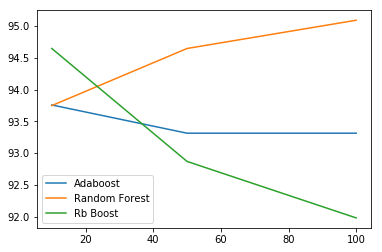

In [13]:
df = pd.DataFrame(data=total_accuracy,index= [10, 50, 100])
# df = df.cumsum()
print(df)
plt.figure()
df.plot()
plt.show()